In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## 1. Load Dataset

In [2]:
DATA_PATH = 'data_cleaned/automobile_sales_final.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Cleaned dataset not found at {DATA_PATH}")

pd.set_option('display.max_columns', 200)
df = pd.read_csv(DATA_PATH, parse_dates=['ORDERDATE'])
print("Loaded df:", df.shape)

Loaded df: (2668, 34)


## Basic Numerical coercion just for saftey

In [3]:
for col in ['SALES','PROFIT','PRICEEACH','QUANTITYORDERED']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

## Helper plot functions

In [5]:
def show_and_save(fig=None, filename=None):
    plt.tight_layout()
    if filename:
        fig.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

def currency(x, pos):
    return f"${x:,.0f}"

## REAL ANALYSIS

1. Top product lines by revenue and margin


1) Top product lines by revenue & margin
        PRODUCTLINE  TotalSales  TotalProfit  AvgMargin
0      Classic Cars  3415013.54   683002.708   0.118603
6      Vintage Cars  1690331.23   338066.246   0.181429
5  Trucks And Buses  1069568.13   213913.626   0.166552
1       Motorcycles  1004033.01   200806.602   0.188245
2            Planes   941056.92   188211.384   0.182159


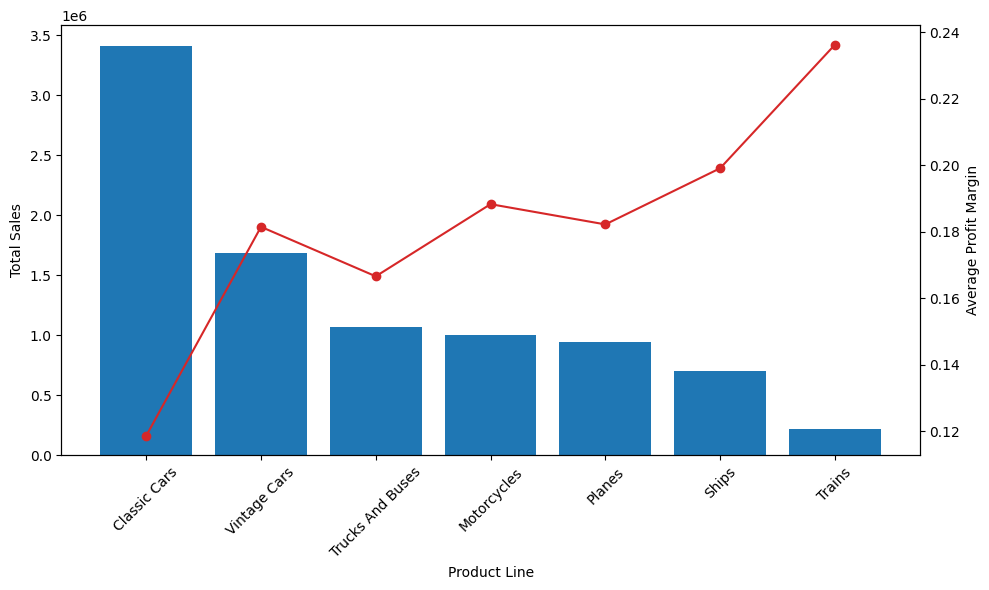

In [6]:
print("\n1) Top product lines by revenue & margin")
prod = df.groupby('PRODUCTLINE').agg(TotalSales=('SALES','sum'),
                                     TotalProfit=('PROFIT','sum'),
                                     AvgMargin=('PROFIT_MARGIN','mean')).reset_index().sort_values('TotalSales', ascending=False)
print(prod.head())

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(prod['PRODUCTLINE'], prod['TotalSales'])
ax1.set_xlabel('Product Line'); ax1.set_ylabel('Total Sales')
ax1.tick_params(axis='x', rotation=45)
ax2 = ax1.twinx()
ax2.plot(prod['PRODUCTLINE'], prod['AvgMargin'], marker='o', color='tab:red')
ax2.set_ylabel('Average Profit Margin')
show_and_save(fig)

2. Seasonality and Trend Analysi (Monthly)


2) Seasonality & trend analysis (monthly)
   ORDERDATE      SALES     PROFIT
0 2018-01-31  129753.60  25950.720
1 2018-02-28  132145.83  26429.166
2 2018-03-31  147552.32  29510.464
3 2018-04-30  184135.25  36827.050
4 2018-05-31  184389.11  36877.822


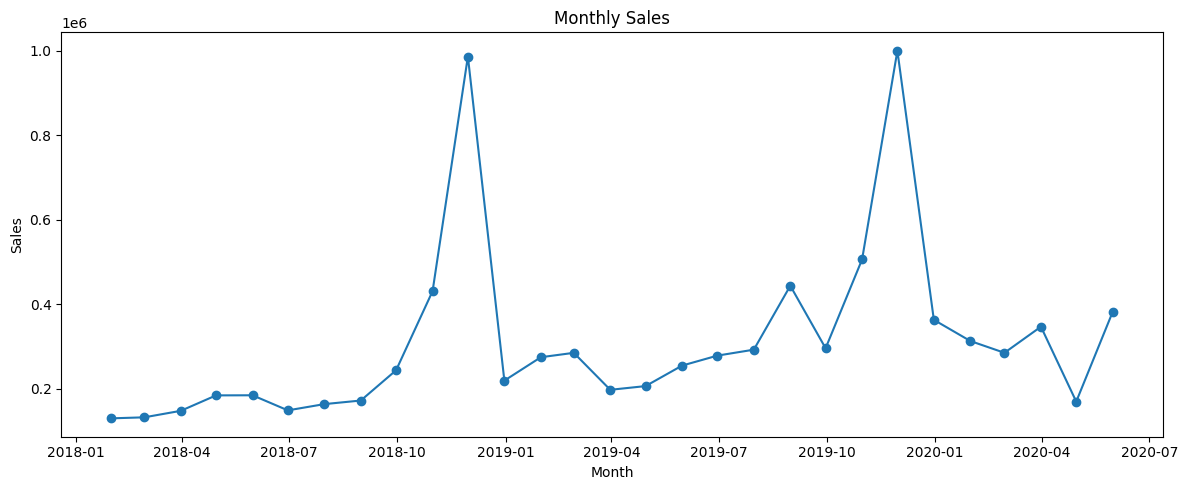

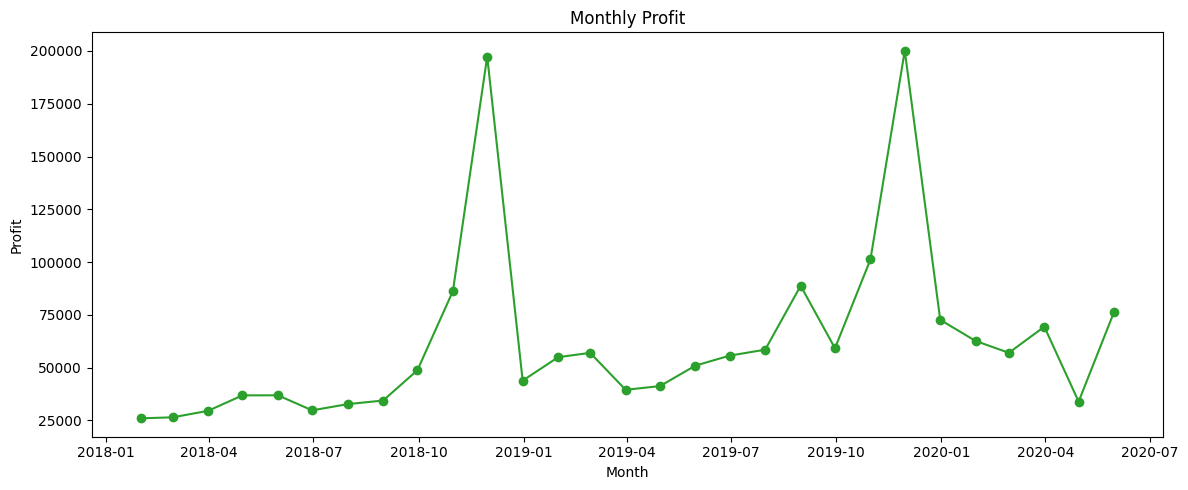

In [8]:
print("\n2) Seasonality & trend analysis (monthly)")
df_ts = df.set_index('ORDERDATE').sort_index()
monthly = df_ts.resample('ME').agg({'SALES':'sum','PROFIT':'sum'}).reset_index()
print(monthly.head())

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(monthly['ORDERDATE'], monthly['SALES'], marker='o')
ax.set_title('Monthly Sales'); ax.set_xlabel('Month'); ax.set_ylabel('Sales')
show_and_save(fig)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(monthly['ORDERDATE'], monthly['PROFIT'], marker='o', color='tab:green')
ax.set_title('Monthly Profit'); ax.set_xlabel('Month'); ax.set_ylabel('Profit')
show_and_save(fig)

3. CLV and Top Customers


3) CLV & top customers
                    CUSTOMERNAME  TotalSales  TotalOrders  TotalProfit  \
32         Euro Shopping Channel   854428.75           26   170885.750   
53  Mini Gifts Distributors Ltd.   591548.67           17   118309.734   
6     Australian Collectors, Co.   181956.52            5    36391.304   
55            Muscle Machine Inc   178318.98            4    35663.796   
43             La Rochelle Gifts   170085.30            4    34017.060   

    AvgOrderValue  
32   32862.644231  
53   34796.980588  
6    36391.304000  
55   44579.745000  
43   42521.325000  


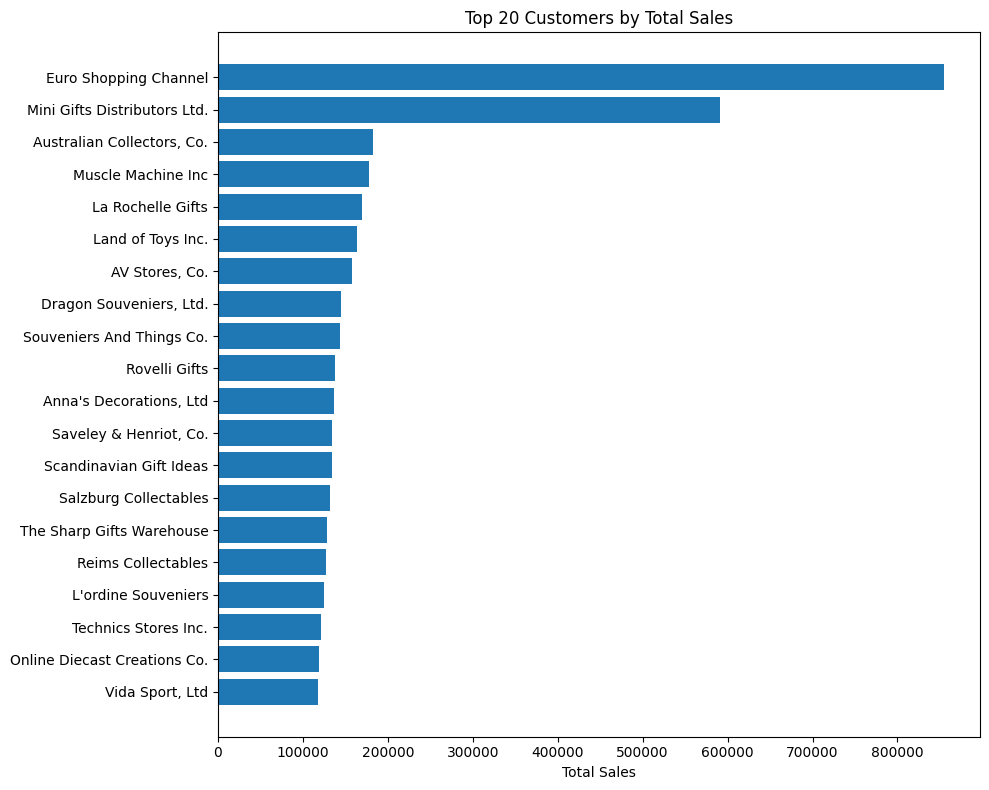

In [9]:
print("\n3) CLV & top customers")
clv = df.groupby('CUSTOMERNAME').agg(TotalSales=('SALES','sum'),
                                     TotalOrders=('ORDERNUMBER','nunique'),
                                     TotalProfit=('PROFIT','sum')).reset_index()
clv['AvgOrderValue'] = clv['TotalSales'] / clv['TotalOrders']
top20 = clv.sort_values('TotalSales', ascending=False).head(20)
print(top20.head())

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(top20['CUSTOMERNAME'][::-1], top20['TotalSales'][::-1])
ax.set_title('Top 20 Customers by Total Sales'); ax.set_xlabel('Total Sales')
show_and_save(fig)

4. Recency, Frequency, Monetary (RFM) Analysis


4) RFM analysis
              CUSTOMERNAME  Recency  Frequency   Monetary  R_Score  F_Score  \
0           AV Stores, Co.      197          3  157807.81        3        2   
1             Alpha Cognac       65          3   62156.83        4        2   
2       Amica Models & Co.      266          2   69437.88        1        1   
3  Anna's Decorations, Ltd       84          4  137181.28        4        4   
4        Atelier graphique      189          3   24179.96        3        2   

   M_Score RFM_Segment  
0        5         325  
1        2         422  
2        2         112  
3        5         445  
4        1         321  


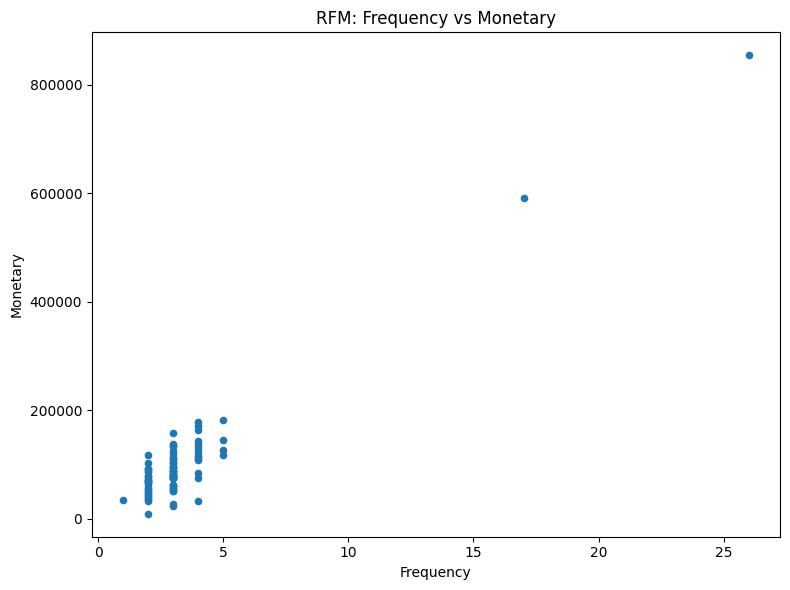

In [10]:
print("\n4) RFM analysis")
reference_date = df['ORDERDATE'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CUSTOMERNAME').agg(Recency=('ORDERDATE', lambda x: (reference_date - x.max()).days),
                                     Frequency=('ORDERNUMBER','nunique'),
                                     Monetary=('SALES','sum')).reset_index()
# assign simple quintile scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Segment'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)
print(rfm.head())

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(rfm['Frequency'], rfm['Monetary'], s=20)
ax.set_xlabel('Frequency'); ax.set_ylabel('Monetary'); ax.set_title('RFM: Frequency vs Monetary')
show_and_save(fig)

5. Discounting & Price Sensitivity


5) Discount & price sensitivity
  DISCOUNT_BUCKET     AvgQty  AvgMargin  CountOrders
0              0%  34.078125   0.202656           58
1            0-5%  35.501818   0.178582          172
2           5-10%  35.188356   0.132329          174
3          10-20%  35.001661   0.055515          218
4            >20%  35.183544  -0.601582           42


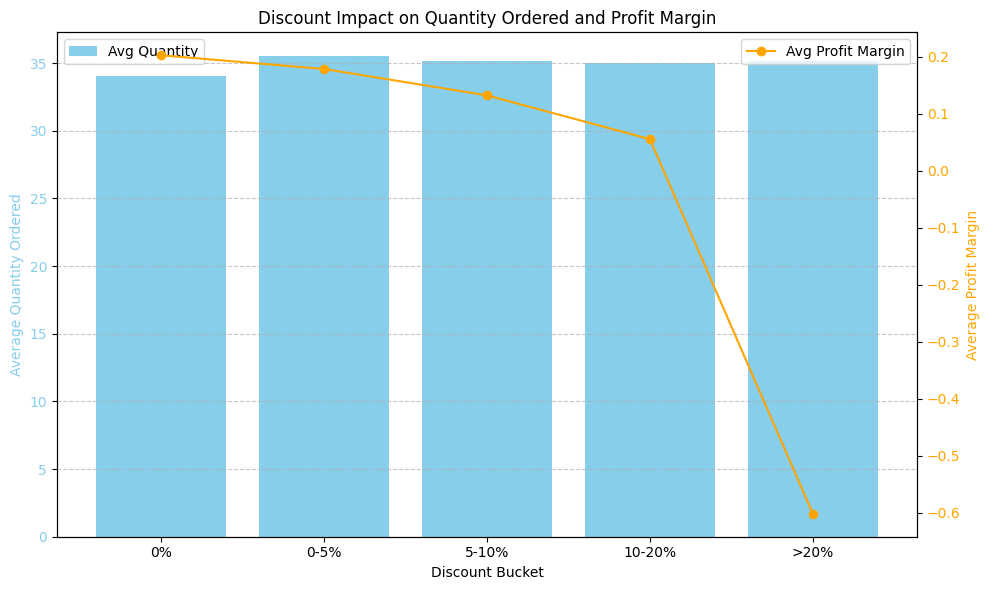

In [15]:
print("\n5) Discount & price sensitivity")

# Ensure MSRP is numeric and calculate discount %
if 'MSRP' in df.columns:
    df['MSRP'] = pd.to_numeric(df['MSRP'], errors='coerce')
    df['DISCOUNT_PCT'] = ((df['MSRP'] - df['PRICEEACH']) / df['MSRP']).fillna(0)
else:
    df['DISCOUNT_PCT'] = 0.0

# Bucket the discounts
df['DISCOUNT_BUCKET'] = pd.cut(
    df['DISCOUNT_PCT'],
    bins=[-0.01,0,0.05,0.1,0.2,1.0],
    labels=['0%','0-5%','5-10%','10-20%','>20%']
)

# Group by discount bucket
sens = (
    df.groupby('DISCOUNT_BUCKET', observed=True)
      .agg(
          AvgQty=('QUANTITYORDERED', 'mean'),
          AvgMargin=('PROFIT_MARGIN', 'mean'),
          CountOrders=('ORDERNUMBER', 'nunique')
      )
      .reset_index()
)

print(sens)

# ----------------------------
# Plot the results
# ----------------------------
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot: Average Quantity
ax1.bar(sens['DISCOUNT_BUCKET'], sens['AvgQty'], color='skyblue', label='Avg Quantity')
ax1.set_xlabel('Discount Bucket')
ax1.set_ylabel('Average Quantity Ordered', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Create a second y-axis for Avg Margin
ax2 = ax1.twinx()
ax2.plot(sens['DISCOUNT_BUCKET'], sens['AvgMargin'], color='orange', marker='o', label='Avg Profit Margin')
ax2.set_ylabel('Average Profit Margin', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title & grid
plt.title('Discount Impact on Quantity Ordered and Profit Margin')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Show legend
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

6. Profitability by country & Product matrix


6) Profitability by country & product line (pivot)
PRODUCTLINE  Classic Cars  Motorcycles     Planes      Ships     Trains  \
COUNTRY                                                                   
Usa            224633.864    88163.762  60905.168  39058.046  13850.712   
Spain           87121.346    13083.332  17997.102  24891.994   8674.036   
France          62999.764    41842.682  19623.182  13297.334   3672.750   
Australia       35328.740    14185.974  14970.774    831.952    336.270   
Uk              31875.540     4053.514   8232.702  14591.834   2527.108   

PRODUCTLINE  Trucks And Buses  Vintage Cars  
COUNTRY                                      
Usa                 74680.466    119904.460  
Spain               32217.884     43996.002  
France              23396.444     33377.962  
Australia           13769.672     34650.830  
Uk                   5628.598     24759.748  


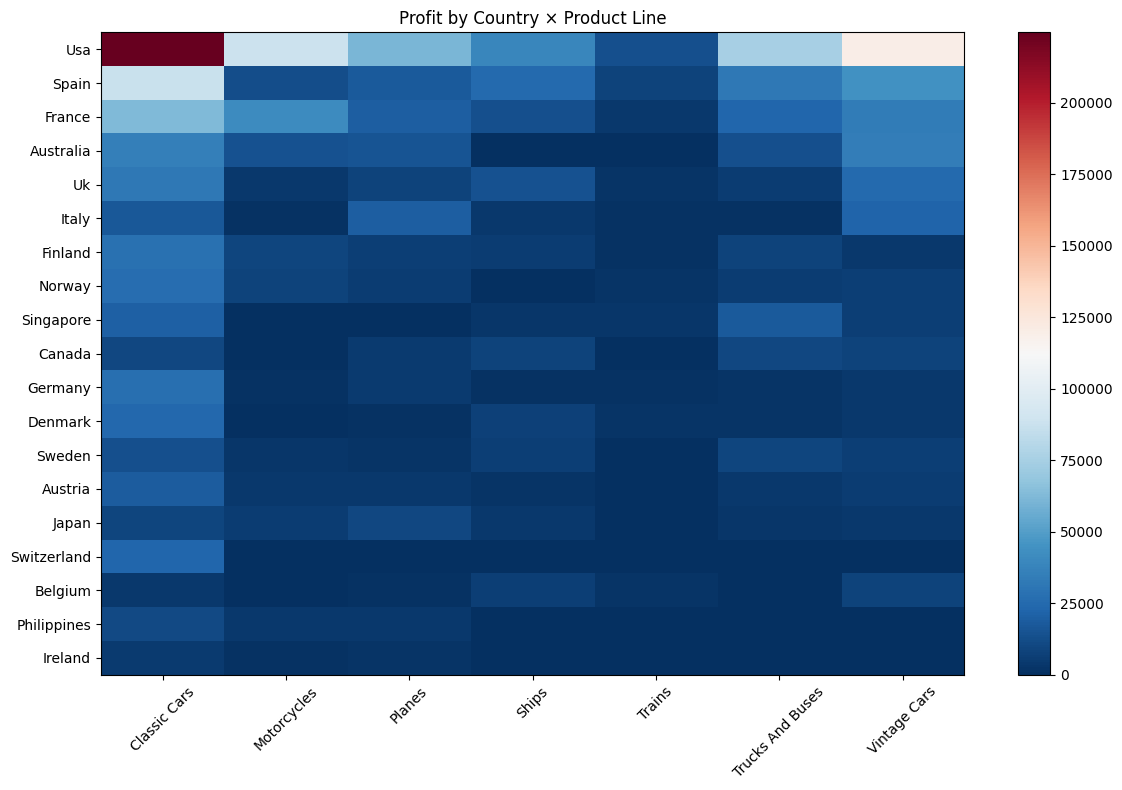

In [17]:
print("\n6) Profitability by country & product line (pivot)")
pivot = pd.pivot_table(df, index='COUNTRY', columns='PRODUCTLINE', values='PROFIT', aggfunc='sum', fill_value=0)
pivot_sorted = pivot.sum(axis=1).sort_values(ascending=False)
pivot = pivot.loc[pivot_sorted.index]
print(pivot.head())

fig, ax = plt.subplots(figsize=(12,8))
cax = ax.imshow(pivot.fillna(0).values, aspect='auto', cmap='RdBu_r')  # Red-Blue colormap
ax.set_xticks(range(len(pivot.columns))); ax.set_xticklabels(pivot.columns, rotation=45)
ax.set_yticks(range(len(pivot.index))); ax.set_yticklabels(pivot.index)
ax.set_title('Profit by Country × Product Line')
fig.colorbar(cax)
show_and_save(fig)

7. Cumulative Revenue & Profit


7) Cumulative revenue & profit


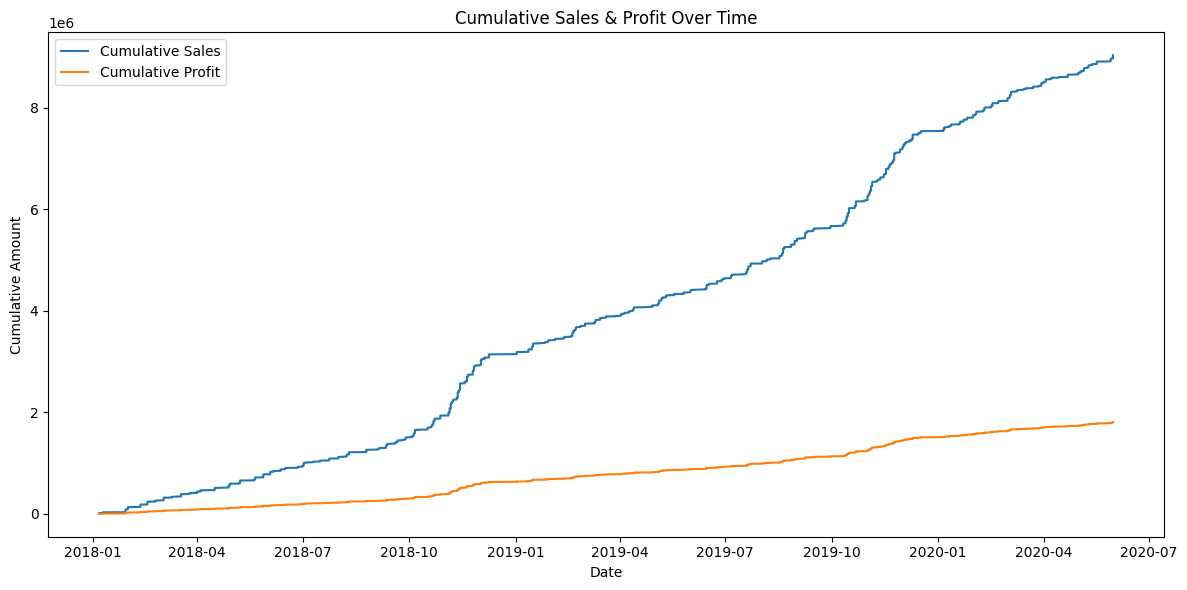

In [18]:
print("\n7) Cumulative revenue & profit")
df_sorted = df.sort_values('ORDERDATE').copy()
df_sorted['CUM_SALES'] = df_sorted['SALES'].cumsum()
df_sorted['CUM_PROFIT'] = df_sorted['PROFIT'].cumsum()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_sorted['ORDERDATE'], df_sorted['CUM_SALES'], label='Cumulative Sales')
ax.plot(df_sorted['ORDERDATE'], df_sorted['CUM_PROFIT'], label='Cumulative Profit')
ax.set_xlabel('Date'); ax.set_ylabel('Cumulative Amount'); ax.legend(); ax.set_title('Cumulative Sales & Profit Over Time')
show_and_save(fig)


8) Order status & revenue leakage


8) Order status and revenue at risk
       STATUS  NumOrders  TotalSales  SalesPct
0   Cancelled          4   194487.48  0.021521
1    Disputed          3    44151.11  0.004885
2  In Process          6   124759.60  0.013805
3     On Hold          4   164896.39  0.018246
4    Resolved          4   141833.48  0.015694
5     Shipped        277  8367180.41  0.925849


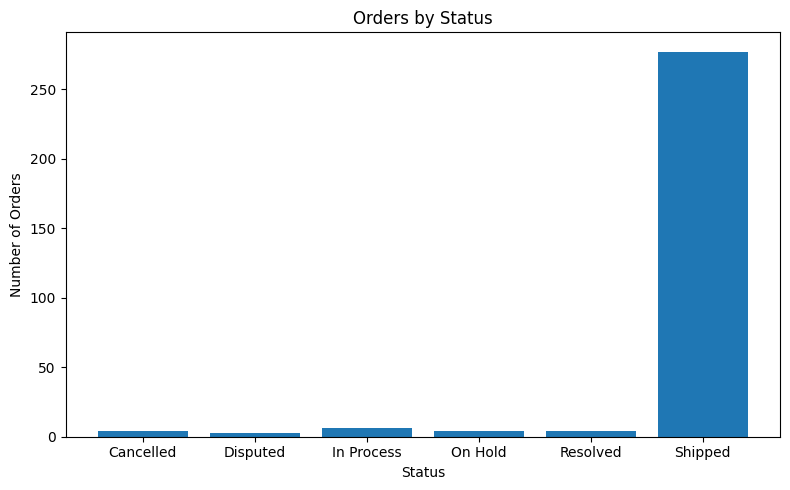

In [22]:
print("\n8) Order status and revenue at risk")
status = df.groupby('STATUS').agg(NumOrders=('ORDERNUMBER','nunique'), TotalSales=('SALES','sum')).reset_index()
status['SalesPct'] = status['TotalSales'] / status['TotalSales'].sum()
print(status)

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(status['STATUS'], status['NumOrders'])
ax.set_xlabel('Status'); ax.set_ylabel('Number of Orders'); ax.set_title('Orders by Status')
show_and_save(fig)

9) Correlation & Regression (Profit ~ Sales + Quantity [+ Discount])


10) Correlation matrix and regression

Correlation matrix:
                          SALES    PROFIT  PRICEEACH  QUANTITYORDERED  \
SALES                 1.000000  1.000000   0.785377         0.518817   
PROFIT                1.000000  1.000000   0.785377         0.518817   
PRICEEACH             0.785377  0.785377   1.000000        -0.072804   
QUANTITYORDERED       0.518817  0.518817  -0.072804         1.000000   
PROFIT_MARGIN         0.247767  0.247767   0.317300        -0.033330   
DAYS_SINCE_LASTORDER  0.110948  0.110948   0.155853        -0.019934   
DISCOUNT_PCT         -0.232500 -0.232500  -0.317249         0.047815   

                      PROFIT_MARGIN  DAYS_SINCE_LASTORDER  DISCOUNT_PCT  
SALES                      0.247767              0.110948     -0.232500  
PROFIT                     0.247767              0.110948     -0.232500  
PRICEEACH                  0.317300              0.155853     -0.317249  
QUANTITYORDERED           -0.033330             -0.019934      0.0

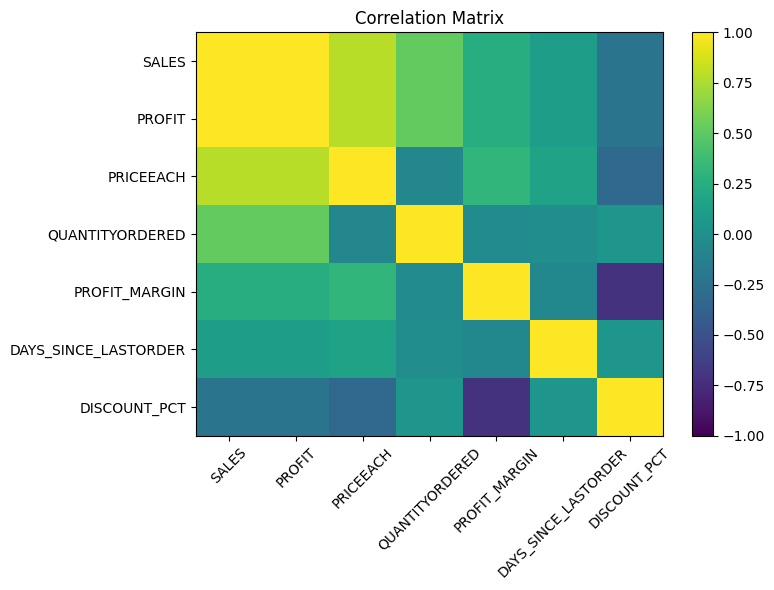


Sklearn Linear Regression:
Features: ['SALES', 'QUANTITYORDERED', 'DISCOUNT_PCT']
Coefficients: [ 2.00000000e-01 -2.70263259e-16 -3.02315178e-15]
Intercept: -2.2737367544323206e-13
R^2: 1.0000
MSE: 0.0000

Statsmodels OLS summary:

                            OLS Regression Results                            
Dep. Variable:                 PROFIT   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.254e+32
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:59:54   Log-Likelihood:                 71187.
No. Observations:                2668   AIC:                        -1.424e+05
Df Residuals:                    2664   BIC:                        -1.423e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                   

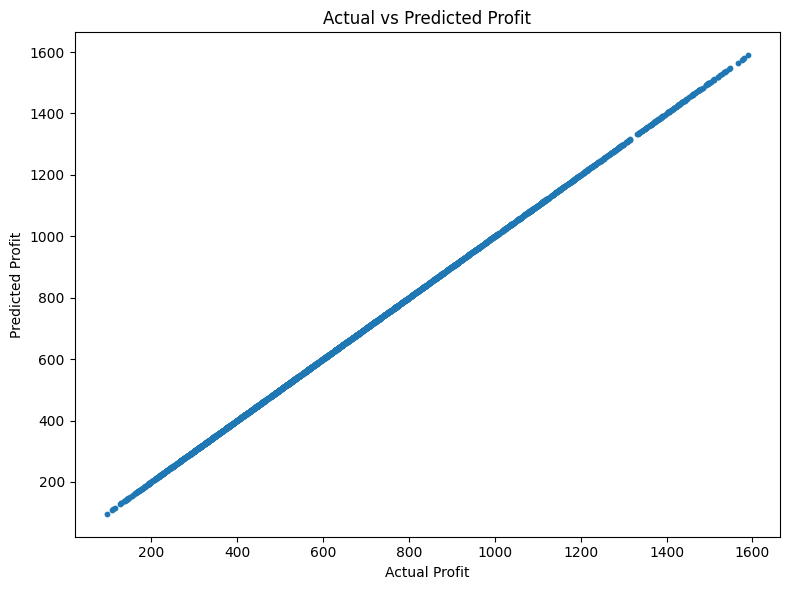

In [23]:
print("\n10) Correlation matrix and regression")
num_cols = ['SALES','PROFIT','PRICEEACH','QUANTITYORDERED','PROFIT_MARGIN','DAYS_SINCE_LASTORDER']
if 'DISCOUNT_PCT' in df.columns:
    num_cols.append('DISCOUNT_PCT')
num_cols = [c for c in num_cols if c in df.columns]
corr = df[num_cols].corr()
print("\nCorrelation matrix:\n", corr)

fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(corr.values, vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticks(range(len(corr.index))); ax.set_yticklabels(corr.index)
ax.set_title('Correlation Matrix')
fig.colorbar(cax)
show_and_save(fig)

# Prepare regression data
reg_df = df.copy().dropna(subset=['PROFIT','SALES','QUANTITYORDERED'])
X_cols = ['SALES','QUANTITYORDERED']
if 'DISCOUNT_PCT' in reg_df.columns and reg_df['DISCOUNT_PCT'].notna().any():
    X_cols.append('DISCOUNT_PCT')

X = reg_df[X_cols].values
y = reg_df['PROFIT'].values

# sklearn LinearRegression
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print("\nSklearn Linear Regression:")
print("Features:", X_cols)
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")

# Statsmodels OLS for full summary
X_sm = sm.add_constant(reg_df[X_cols])
model = sm.OLS(reg_df['PROFIT'], X_sm).fit()
print("\nStatsmodels OLS summary:\n")
print(model.summary())

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(y, y_pred, s=10)
ax.set_xlabel('Actual Profit'); ax.set_ylabel('Predicted Profit'); ax.set_title('Actual vs Predicted Profit')
show_and_save(fig)

## Final KPI prints

In [24]:
print("\n--- KPIs ---")
total_revenue = df['SALES'].sum()
total_profit = df['PROFIT'].sum()
gross_margin = total_profit / total_revenue if total_revenue != 0 else np.nan
aov = df.groupby('ORDERNUMBER')['SALES'].sum().mean()
avg_profit_per_order = df.groupby('ORDERNUMBER')['PROFIT'].sum().mean()
repeat_rate = df[df['CUSTOMER_TYPE']=='Repeat']['CUSTOMERNAME'].nunique() / df['CUSTOMERNAME'].nunique()
cancel_rate = df[df['STATUS']=='Cancelled']['ORDERNUMBER'].nunique() / df['ORDERNUMBER'].nunique()

print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Gross Profit Margin: {gross_margin:.2%}")
print(f"AOV: ${aov:,.2f}")
print(f"Avg Profit / Order: ${avg_profit_per_order:,.2f}")
print(f"Repeat Customer Rate: {repeat_rate:.2%}")
print(f"Order Cancellation Rate: {cancel_rate:.2%}")

# End
print("\nAnalysis complete. Inspect plots and printed outputs for insights.")


--- KPIs ---
Total Revenue: $9,037,308.47
Total Profit: $1,807,461.69
Gross Profit Margin: 20.00%
AOV: $30,326.54
Avg Profit / Order: $6,065.31
Repeat Customer Rate: 100.00%
Order Cancellation Rate: 1.34%

Analysis complete. Inspect plots and printed outputs for insights.


## Derived Fields

In [27]:
# 1️⃣ Calculate Profit (assuming cost = 80% of price * quantity)
df['PROFIT'] = df['SALES'] - (df['QUANTITYORDERED'] * df['PRICEEACH'] * 0.8)

# 2️⃣ Calculate Profit Margin
df['PROFIT_MARGIN'] = df['PROFIT'] / df['SALES']

# 3️⃣ Identify Repeat vs One-Time Customers
df['CUSTOMER_TYPE'] = df.duplicated(subset=['CUSTOMERNAME'], keep=False).map({True:'Repeat', False:'One-Time'})

# 4️⃣ Calculate Discount Percentage (if MSRP exists)
if 'MSRP' in df.columns:
    df['MSRP'] = pd.to_numeric(df['MSRP'], errors='coerce')
    df['DISCOUNT_PCT'] = ((df['MSRP'] - df['PRICEEACH']) / df['MSRP']).fillna(0)
else:
    df['DISCOUNT_PCT'] = 0.0

# 5️⃣ Assign Discount Buckets for analysis
df['DISCOUNT_BUCKET'] = pd.cut(df['DISCOUNT_PCT'],
                               bins=[-0.01,0,0.05,0.1,0.2,1.0],
                               labels=['0%','0-5%','5-10%','10-20%','>20%'])

# 6️⃣ Cumulative Sales & Profit (chronological)
df = df.sort_values('ORDERDATE')
df['CUM_SALES'] = df['SALES'].cumsum()
df['CUM_PROFIT'] = df['PROFIT'].cumsum()

# 7️⃣ Optional: Days since last order per customer
df['DAYS_SINCE_LASTORDER'] = df.groupby('CUSTOMERNAME')['ORDERDATE'].diff().dt.days.fillna(0)

# 8️⃣ RFM derived fields
reference_date = df['ORDERDATE'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CUSTOMERNAME').agg(
    Recency=('ORDERDATE', lambda x: (reference_date - x.max()).days),
    Frequency=('ORDERNUMBER','nunique'),
    Monetary=('SALES','sum')
).reset_index()

# Assign RFM quintiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Segment'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)

# Merge RFM back into main df if needed
df = df.merge(rfm[['CUSTOMERNAME','R_Score','F_Score','M_Score','RFM_Segment']], on='CUSTOMERNAME', how='left')
df.to_csv('data_cleaned/automobile_sales_final_derived.csv', index=False)
print("Derived fields calculated and dataset saved ✅")


Derived fields calculated and dataset saved ✅
